<a href="https://colab.research.google.com/github/mohammadalirezaee/featureExtractor_ethUCY/blob/main/feature_extractor_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://data.vision.ee.ethz.ch/cvl/aem/ewap_dataset_full.tgz
!mkdir /content/ eth
!tar -xf ewap_dataset_full.tgz -C /content/eth
!git clone https://github.com/mohammadalirezaee/nuscenes_test.git
!git clone https://github.com/mohammadalirezaee/featureExtractor_ethUCY.git

In [ ]:
!git init
!git config — global user.email 'mohammadalire94@gmail.com'
!git config — global user.name 'mohammadalirezaee'
!git add -A
!git commit -m "first commit"

In [2]:
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.transforms import transforms
from dataloader_frames import *
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import torch.nn as nn
from torch.nn.functional import relu

In [3]:
dataset_dir = '/content/nuscenes_test/nuscenes_test_cpu/datasets/test'
loader_train = get_dataloader(dataset_dir, 'train', 8, 12 ,batch_size=1)

list_of_data = []
for data in loader_train:
  list_of_data.append(data)

list_of_frame = [i[6][0].tolist() for i in list_of_data]

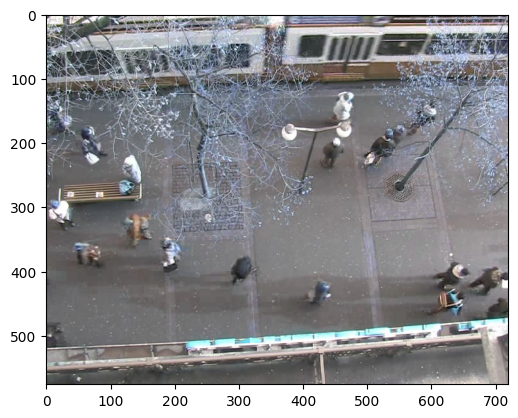

In [12]:
cap = cv2.VideoCapture('/content/eth/ewap_dataset/seq_hotel/seq_hotel.avi')
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.set(cv2.CAP_PROP_POS_FRAMES, 10)
ret, frame = cap.read()
plt.imshow(frame)

In [ ]:
transformed_image = transform(frame)
transformed_image = transformed_image.unsqueeze(0)

deeplab_v3_decoder

unet_encoder

In [4]:
class modified_UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        # input: 224*224
        self.e11 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

    def forward(self, x):
            # Encoder
            xe11 = relu(self.e11(x))
            xe12 = relu(self.e12(xe11))
            xp1 = self.pool1(xe12)

            xe41 = relu(self.e41(xp1))
            xe42 = relu(self.e42(xe41))
            xp4 = self.pool4(xe42)

            xe51 = relu(self.e51(xp4))
            xe52 = relu(self.e52(xe51))
            return xe52

In [8]:
def prepare_image(frame):
    transform = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize(300),
                      transforms.ToTensor()])
    transformed_image = transform(frame)
    transformed_image = transformed_image.unsqueeze(0)
    return transformed_image.to(device)

def scene_feature(transformed_image , encoder):
    with torch.no_grad():  # 
        features = encoder(transformed_image)
        pool = torch.nn.AdaptiveAvgPool2d((1,1))
        pooled_features = pool(features)
        vector = pooled_features.view(1, -1)
    return vector.cpu().numpy()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cap = cv2.VideoCapture('/content/eth/ewap_dataset/seq_hotel/seq_hotel.avi')
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
obs_length = 8
scene_features = []
encoder = modified_UNet().to(device)
for i in range(len(list_of_frame)):
    current_frame_number = list_of_frame[i][0]
    temp_features = []

    for i in range(obs_length):
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
        ret, current_frame = cap.read()
        frame = prepare_image(current_frame).to(device)  # 
        feature = scene_feature(frame, encoder)
        temp_features.append(feature)
        current_frame_number+=10

    scene_features.append(temp_features)
